# Overview

We splitted the whole project into the 2 tasks of 3D Obejct Detection and Multi-Object tracking. Since the results of the first task were mediocre, we decided to work with the given Lidar Labels as input for the second task. <br>
The whole project can be pulled from: https://github.com/NoahPichl/av-kv <br>
All relevant code is in the Assignemnt2 folder <br><br>

The data should be in a neighbour directory of Assignment2:
```
project
└─Assignment2
|    main.ipynb 
└─Dataset
    └─data_2 
        frame_0.pb 
        frame_1.pb 
        ...
```

# Setup

1. Pull the project from https://github.com/NoahPichl/av-kv
2. Install dependencies from requierements.txt (building the docker container should do that)
3. Create the Dataset directory and import and put the dataset in the directory
4. The notebook `main.ipynb` should be able to run from top to bottom in the Assignment2 folder

# 3D Object Detection

## Imports

In [1]:
import numpy as np
import os
from PIL import Image
import cv2
import copy
from glob import glob

import ObjectDetection.Open3D_ML.ml3d as _ml3d
import ObjectDetection.Open3D_ML.ml3d.torch as tml3d
from ObjectDetection.TaskDataset import TaskDataset


import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Model

We chose PointPillars as our model, since open3D_ML provides an implementation for the models, as well as corresponding model weights trained on the waymo dataset. PointPillars is a widely adapted method for Object Detection based on point clouds. The model architecture follows rougly 3 steps:
1. First the a Pillar Feature Net is used to transform the point cloud into a pseudo image
2. The pseudo image is than fed into a CNN to perform feature extraction 
3. A detection head is used to locate and predict object on the extracted features

Due to the natur of the model, we did not needed to create an BEV map of the point cloud. Most of the dataloading and preprocessing is implemented in `TaskDataset.py`

## Model loading

Load model weigths from pointpillars_waymo.pth <br>
The model configuration and general pipeline-settings are defined in pointpillars_waymo.yml

In [2]:
cfg_file = "/workspaces/AutomotiveVehicles/Assignment2/ObjectDetection/pointpillars_waymo.yml"
cfg =  _ml3d.utils.Config.load_from_file(cfg_file)

model = tml3d.models.PointPillars(**cfg.model)
dataset = TaskDataset(cfg.dataset)
pipeline = tml3d.pipelines.ObjectDetection(model, dataset=dataset, device="gpu", **cfg.pipeline)

# download the weights.
ckpt_folder = "./logs/"
os.makedirs(ckpt_folder, exist_ok=True)
ckpt_path = ckpt_folder + "pointpillars_waymo_202211200158utc_seed2_gpu16.pth"
pointpillar_url = "https://storage.googleapis.com/open3d-releases/model-zoo/pointpillars_waymo_202211200158utc_seed2_gpu16.pth"
if not os.path.exists(ckpt_path):
    cmd = "wget {} -O {}".format(pointpillar_url, ckpt_path)
    os.system(cmd)

# load the parameters.
_ = pipeline.load_ckpt(ckpt_path=ckpt_path)

## Evaluation

We load the data an run the validation on the provided dataset. The results are saved in a log file, which we display in the second cell

In [3]:
data_split = dataset.get_split("valid")
print("Number of samples: ", len(data_split))
pipeline.run_valid()

Number of samples:  199


validation:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
validation: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


In [4]:
files = glob("logs/PointPillars_MyDataset_torch/*.txt")
files.sort()
with open(files[-1], "r") as f:
    lines = f.read()
print(lines)

Started validation
validation -  loss_cls: 1.223 loss_bbox: 5.661 loss_dir: 0.444 > loss: 7.328

=============== mAP BEV ===============
class \ difficulty      0     1     2 
VEHICLE:             28.41 28.41 28.41 
PEDESTRIAN:           0.00  0.00  0.00 
CYCLIST:              0.00  0.00  0.00 
Overall: 9.47

=============== mAP  3D ===============
class \ difficulty      0     1     2 
VEHICLE:             28.88 28.88 28.88 
PEDESTRIAN:           0.00  0.00  0.00 
CYCLIST:              0.00  0.00  0.00 
Overall: 9.63



Here we can already see that the performance is worse compared to the reported results on the full waymo dataset.

## Visualization

For the visualization of the results we reuse part of the Example notebook and extend the plot function to display the labels and the prediciton of one sample

In [5]:
from easydict import EasyDict as edict
from typing import Tuple
from numpy import sin, cos

def pcl_to_bev(pcl:np.ndarray, configs: edict) -> np.ndarray:
    """Computes the bev map of a given pointcloud. 
    
    For generality, this method can return the bev map of the available 
    channels listed in '''BEVConfig.VALID_CHANNELS'''. 

    Parameters
    ----------
        pcl (np.ndarray): pointcloud as a numpy array of shape [n_points, m_channles] 
        configs (Dict): configuration parameters of the resulting bev_map

    Returns
    -------
        bev_map (np.ndarray): bev_map as numpy array of shape [len(config.channels), configs.bev_height, configs.bev_width ]
    """
    
    # remove lidar points outside detection area and with too low reflectivity
    mask = np.where((pcl[:, 0] >= configs.lims.x[0]) & (pcl[:, 0] <= configs.lims.x[1]) &
                    (pcl[:, 1] >= configs.lims.y[0]) & (pcl[:, 1] <= configs.lims.y[1]) &
                    (pcl[:, 2] >= configs.lims.z[0]) & (pcl[:, 2] <= configs.lims.z[1]))
    pcl = pcl[mask]

    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    pcl[:, 2] = pcl[:, 2] - configs.lims.z[0]  

    # Convert sensor coordinates to bev-map coordinates (center is bottom-middle)
    # compute bev-map discretization by dividing x-range by the bev-image height
    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width
    ## transform all metrix x-coordinates into bev-image coordinates    
    pcl_cpy = np.copy(pcl)
    pcl_cpy[:, 0] = np.int_(np.floor(pcl_cpy[:, 0] / bev_x_discret))
    # transform all y-coordinates making sure that no negative bev-coordinates occur
    pcl_cpy[:, 1] = np.int_(np.floor(pcl_cpy[:, 1] / bev_y_discret) + (configs.bev_width + 1) / 2) 
    # Create BEV map
    bev_map = np.zeros((3, configs.bev_height, configs.bev_width))
    # Compute height and density channel
    pcl_height_sorted, counts = sort_and_map(pcl_cpy, 2, return_counts=True)
    xs = np.int_(pcl_height_sorted[:, 0])
    ys = np.int_(pcl_height_sorted[:, 1])
    # Fill height map
    normalized_height = pcl_height_sorted[:, 2]/float(np.abs(configs.lims.z[1] - configs.lims.z[0]))
    height_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    height_map[xs,ys] = normalized_height
    
    # Fill density map
    normalized_density = np.minimum(1.0, np.log(counts + 1) / np.log(64))
    density_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    density_map[xs,ys] = normalized_density

    # Compute intesity channel
    pcl_cpy[pcl_cpy[:,3]>configs.lims.intensity[1],3] = configs.lims.intensity[1]
    pcl_cpy[pcl_cpy[:,3]<configs.lims.intensity[0],3] = configs.lims.intensity[0]
    
    pcl_int_sorted, _ = sort_and_map(pcl_cpy, 3, return_counts=False)
    xs = np.int_(pcl_int_sorted[:, 0])
    ys = np.int_(pcl_int_sorted[:, 1])
    normalized_int = pcl_int_sorted[:, 3]/(np.amax(pcl_int_sorted[:, 3])-np.amin(pcl_int_sorted[:, 3]))
    intensity_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    intensity_map[xs,ys] = normalized_int
    
    # Fill BEV 
    bev_map[2,:,:] = density_map[:configs.bev_height, :configs.bev_width]
    bev_map[1,:,:] = height_map[:configs.bev_height, :configs.bev_width]
    bev_map[0,:,:] = intensity_map[:configs.bev_height, :configs.bev_width]
 
    return bev_map

def sort_and_map(pcl: np.ndarray, channel_index: int, return_counts:bool=False) ->Tuple[np.ndarray,np.ndarray]:
    """Function to re-arrange elements in poincloud by sorting first by x, then y, then -channel.
    This function allows users to map a pointcloud channel to a top view image (in z axis) of that channel.

    Parameters
    ----------
        pcl (np.ndarray): Input pointcloud of of shape [n_points, m_channles]
        channel_index (int): Index of channel to take into account as third factor, 
                             when sorting the pointcloud.
        return_counts (bool): True to return the counts on points per cell. Used for density channel
    Returns
     ----------
       channel_map (np.ndarray): [description]
       counts (np.ndarray): [description]
       
    """

    idx= np.lexsort((-pcl[:, channel_index], pcl[:, 1], pcl[:, 0]))
    pcl_sorted = pcl[idx]
    counts = None
    # extract all points with identical x and y such that only the maximum value of the channel is kept
    if return_counts:
        _, indices, counts = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True, return_counts=return_counts)
    else:
        _, indices = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True)
    return (pcl_sorted[indices], counts)

def show_bev_map(bev_map: np.ndarray) -> None:
    """Function to show bev_map as an RGB image

    By default, the image will only show the 3 first channels of `bev_map`. 

    Parameters
    ----------
        bev_map (np.ndarray): bev_map as numpy array of shape `[len(config.channels), configs.bev_height, configs.bev_width ]` 
    """
    bev_image: np.ndarray =  (np.swapaxes(np.swapaxes(bev_map,0,1),1,2)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])


    height_image = Image.fromarray(np.dstack((bev_image[:, :, 0],mask,mask)))
    den_image = Image.fromarray(np.dstack((mask,bev_image[:, :, 1],mask)))
    int_image = Image.fromarray(np.dstack((mask,mask,bev_image[:, :, 2])))

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()

def rotated_rectangle(image, center_point, height, width, angle, color, thickness, ):
    # Determine the coordinates of the 4 corner points
    rotated_rect_points = []
    x = center_point[0] + ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] - ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1]- ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] + ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    return cv2.polylines(image, np.array([rotated_rect_points], np.int32), True, color, thickness)

def show_bounding_boxes(bev_map: np.ndarray, configs, labels, pred) -> np.ndarray:
    bev_image: np.ndarray =  (np.moveaxis(bev_map, 0, -1)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])

    height_image = np.dstack((bev_image[:, :, 0],mask,mask))
    den_image = np.dstack((mask,bev_image[:, :, 1],mask))
    int_image = np.dstack((mask,mask,bev_image[:, :, 2]))

    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width


    for boxes, color in zip([labels, pred], [[200, 0, 200], [0, 200, 200]]):
        for box in boxes:
            x, y, z, l, w, h, r = box.to_xyzwhlr()

            x = np.int_(np.floor(x / bev_x_discret))
            l = np.int_(np.floor(l / bev_x_discret))
            y = np.int_(np.floor(y / bev_y_discret) + (configs.bev_width + 1) / 2)
            w = np.int_(np.floor(w / bev_y_discret))

            int_image = rotated_rectangle(int_image, (y, x), l, w, r, color, 1)
            den_image = rotated_rectangle(den_image, (y, x), l, w, r, color, 1)
            height_image = rotated_rectangle(height_image, (y, x), l, w, r, color, 1)
            bev_image = rotated_rectangle(bev_image.copy(), (y, x), l, w, r, color, 1)
        
    height_image = Image.fromarray(height_image)
    den_image = Image.fromarray(den_image)
    int_image = Image.fromarray(int_image)

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()

configs = edict()
configs.lims = edict()
configs.lims.x = [0, 50]
configs.lims.y = [-25, 25]
configs.lims.z = [-1.5, 3]
configs.lims.intensity = [0, 1.0]
configs.bev_height = 640
configs.bev_width = 640

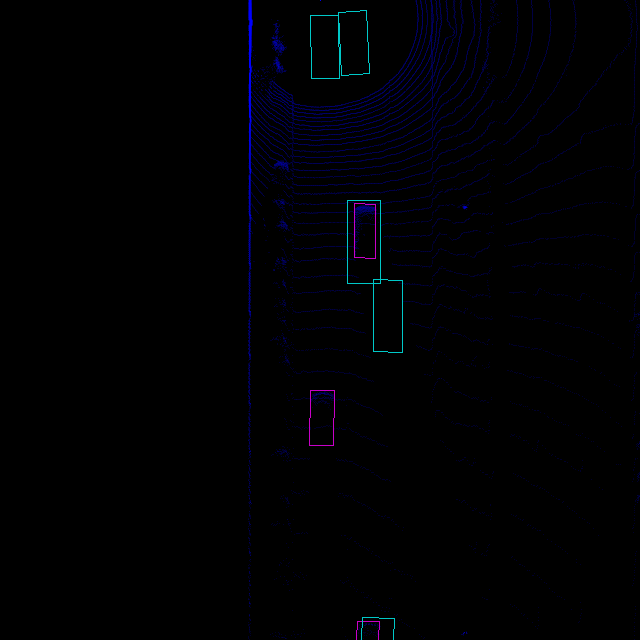

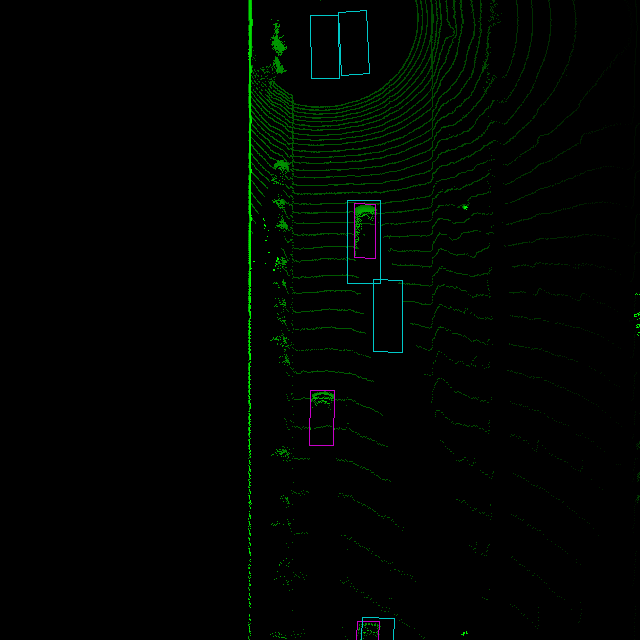

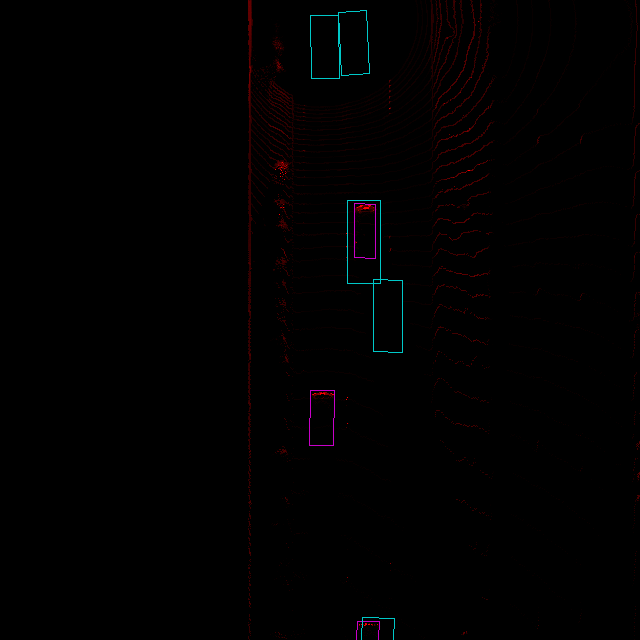

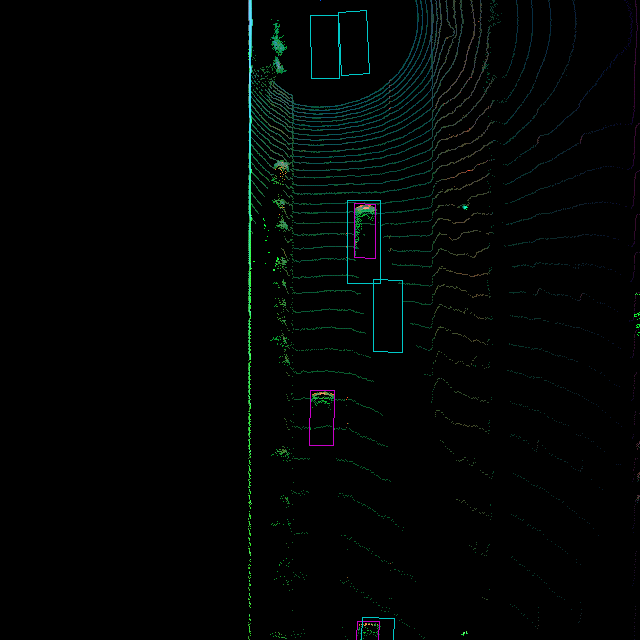

In [6]:
data = data_split.get_data(0)
result = pipeline.run_inference(data)
pcl = data["point"]

bev_map = pcl_to_bev(pcl, configs)
show_bounding_boxes(bev_map, configs, data["bounding_boxes"], result[0])

The labels are displayed with Magenta and the predicitons with Cyan. <br>
We can observe a lot of false positives as well as some false negatives. Interestingly the models tends to predict vehicles in areas, where no data-points are present.

# 2 Multi Object Tracking

The whole tracking pipeline is broken down into several steps which are described next:

1. Data Collection
    * Sensors: The pipeline begins by collecting data from various sensors:
        * Cameras provide 2D images from which object positions are inferred (x, y coordinates in the image plane).
        * Lidars give 3D spatial data, typically used to determine precise distances and relative positions of objects in 3D space, but here simplified to 2D (x, y).

2. Data Extraction
    * Detection Extraction: From the raw sensor outputs, specific features or measurements are extracted:
        * From Camera: The bounding boxes of the detections are used to get the center points.
        * From Lidar: Points are identified to localize objects in 2D space (x and y).

3. Initialization of Tracking
    * Track Creation: When new objects are detected and no existing tracks are found to correspond to these new detections, new tracks are initialized:
        * Each track is equipped with a Kalman Filter initialized to the detected position, with an assumed (zero) initial velocity.
        * The state covariance is set high to reflect initial uncertainty about the state of each new track.

4. Prediction
    * State Prediction: For each existing track, the Kalman Filter predicts the next state based on the previous state and the model of motion (defined by the transition matrix F):
        * This prediction extends the understanding of where each tracked object might move in the next time step, accounting for inherent uncertainties and the dynamics of motion (like velocity).

5. Data Association
    * Matching Detections to Tracks: This crucial step determines which detections correspond to which existing tracks:
        * A cost matrix is constructed based on the distance (e.g., Euclidean) between predicted positions of tracks and new detections.

6. Update
    * State Update: Once detections are associated with tracks, the Kalman Filter for each track updates its state with the new measurement:
        * The update adjusts the tracked position and velocity to more closely reflect the observed data, improving the accuracy of the track.

7. Maintenance
    * Track Management: Tracks are managed continuously to ensure they remain relevant and accurate:
        * Pruning: Tracks that have not been updated for several cycles (due to missing detections) are removed to prevent clutter and false tracking.
        * Creation: New tracks are created for detections that weren't associated with any existing track.

8. Visualization
    * Output Visualization: The current state of tracks is visualized on the video or image stream to provide real-time feedback on the tracking performance:

In [7]:
# Install OpenCV for visualization
!pip install opencv-python

In [8]:
## Imports
import tools.frame_pb2 as fpb
import tools.dataset_tools as dataset_tools
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.optimize import linear_sum_assignment
from matplotlib.patches import Rectangle, Circle
import cv2
from tqdm import tqdm

## Constants
max_allowed_missed_frames = 5
update_tracks_threshold = 30
cost_matrix = np.zeros((1, 1), dtype=float)
video_path = "./out.mp4"

### Load Frames

In [9]:
def load_frame(filename):
    frame = dataset_tools.read_frame(filename)
    return frame

### Extract Detections

In [10]:
def extract_detections_from_camera(camera):
    detections = []
    for detection in camera.detections:
        # Assuming bbox is [x0, y0, width, height]
        # Convert bbox to [x_center, y_center]
        x_center = detection.bbox[0] #- detection.bbox[2] / 2
        y_center = detection.bbox[1] #- detection.bbox[3] / 2
        detections.append(np.array([x_center, y_center]))
    return detections

def extract_detections_from_lidar(lidar):
    detections = []
    for detection in lidar.detections:
        # Assuming pos is [x, y, z]
        # Use x and y for 2D tracking
        detections.append(np.array([detection.pos[0], detection.pos[1]]))
    return detections

def extract_detections(frame):
    detections = []
    for camera in frame.cameras:
        detections.extend(extract_detections_from_camera(camera))
    for lidar in frame.lidars:
        detections.extend(extract_detections_from_lidar(lidar))
    return detections

### Kalman Filter Implementation

The Kalman Filter implemented in the code is designed for tracking the position and velocity of an object in two dimensions (2D). It estimates these properties over time based on noisy observations, which might typically come from sensors like cameras or lidar. Here's a breakdown of how each part of the Kalman Filter works and its role in the tracking process:

#### Initialization
* Time Step (dt): This is the time interval between filter updates, which influences the prediction of the next state.
* State Transition Model (F): The matrix F predicts the next state based on the current state. It considers both position and velocity for each dimension (x and y), integrating the effect of the time step on the position due to velocity.
* Process Noise Covariance (Q): The matrix Q represents the process noise covariance, accounting for the uncertainty in the model prediction. It helps the filter to be robust to the inherent inaccuracies of the motion model, particularly by scaling with the square of the time step (dt), reflecting increased uncertainty over longer periods.
* Measurement Model (H): The matrix H maps the predicted state to the measurement space. In this case, it indicates that the measurements directly correspond to position (x, y) and do not include velocity.
* Observation Noise Covariance (R): The matrix R quantifies the expected noise in the measurements. A larger R decreases the weight given to the observations during updates, making the filter trust its model prediction more relative to the noisy observations.

#### Functions
##### initialize
Initializes the filter's state vector (x) with the provided initial position and an optional velocity (defaulting to zero if not provided). This method also sets the initial estimate of the uncertainty (P, the covariance matrix) to a high value, indicating that initially, the exact state of the system is less certain.

##### predict
Uses the state transition model (F) to predict the next state based on the current state and updates the covariance matrix (P) to reflect the increased uncertainty due to the inherent error in the model. This step does not incorporate new measurement data but extrapolates the current state estimate to the next time step.

##### update
Incorporates new measurement data into the state estimate:
* Measurement Residual (y): The difference between the actual measurement and what the model predicted for this measurement.
* Residual Covariance (S): Represents the uncertainty of the residual.
* Kalman Gain (K): Determines how much the new measurement should influence the updated state. A higher gain places more weight on the new measurement relative to the predicted state.
* Updates the state estimate (x) by applying the Kalman Gain to the residual.
* Updates the estimate of the state uncertainty (P) to reflect the reduced uncertainty after incorporating the new measurement.


In [11]:
## Kalman Filter
class KalmanFilter:
    def __init__(self, dt, process_noise_std, measurement_noise_std):
        # Time step
        self.dt = dt

        # State transition model matrix (F)
        self.F = np.array([
            [1, 0, dt, 0],  # Position x and velocity influence
            [0, 1, 0, dt],  # Position y and velocity influence
            [0, 0, 1, 0],   # Velocity x
            [0, 0, 0, 1]    # Velocity y
        ])

        # Process noise covariance matrix (Q)
        q = process_noise_std**2
        self.Q = q * np.array([
            [dt**4/4, 0, dt**3/2, 0],
            [0, dt**4/4, 0, dt**3/2],
            [dt**3/2, 0, dt**2, 0],
            [0, dt**3/2, 0, dt**2]
        ])

        # Measurement model matrix (H)
        self.H = np.array([
            [1, 0, 0, 0],  # Measuring position x
            [0, 1, 0, 0]   # Measuring position y
        ])

        # Observation noise covariance matrix (R)
        r = measurement_noise_std**2
        self.R = r * np.eye(2)

        # Initial state estimate and covariance matrix (not initialized yet)
        self.x = None
        self.P = None

    def initialize(self, initial_position, initial_velocity=None):
        """ Initialize the state and covariance matrices """
        # print(f"Initializing Kalman Filter with initial position: {initial_position}")
        if initial_velocity is None:
            initial_velocity = [0, 0]  # Assume initial velocity is 0 if not provided
        self.x = np.array([initial_position[0], initial_position[1], initial_velocity[0], initial_velocity[1]])
        self.P = np.eye(4)  # High initial uncertainty

    def predict(self):
        """ Predict the state and covariance after time dt """
        # print(f'Predicting Kalman Filter with dt = {self.dt}')
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(self.F, np.dot(self.P, self.F.T)) + self.Q

    def update(self, measurement):
        """ Update the state by a new measurement """
        # print(f'Updating Kalman Filter with measurement = {measurement}')
        z = np.array(measurement)
        y = z - np.dot(self.H, self.x)  # Measurement residual
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R  # Residual covariance
        K = np.dot(self.P, np.dot(self.H.T, np.linalg.inv(S)))  # Kalman gain
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.F.shape[0])
        self.P = np.dot((I - np.dot(K, self.H)), self.P)

### Tracker Implementation

In [12]:
## Tracker Class
class Tracker:
    def __init__(self):
        self.tracks = []
        self.next_id = 1

    def update_tracks(self, detections):
        # Call predict on all existing tracks
        for track in self.tracks:
            track['kf'].predict()

        if not self.tracks:  # If no tracks exist, initialize tracks with each detection
            for det in detections:
                kf = KalmanFilter(dt=0.1, process_noise_std=1.0, measurement_noise_std=1.0)
                kf.initialize(det)
                self.tracks.append({'id': self.next_id, 'kf': kf, 'last_detected': 0})
                self.next_id += 1
            return

        # Association step
        cost_matrix = np.zeros((len(detections), len(self.tracks)))
        for d_index, detection in enumerate(detections):
            for t_index, track in enumerate(self.tracks):
                predicted_position = track['kf'].x[:2]
                cost_matrix[d_index, t_index] = np.linalg.norm(detection - predicted_position)

        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        all_detections = set(range(len(detections)))
        all_tracks = set(range(len(self.tracks)))

        used_detections = set(row_ind)
        unused_detections = all_detections - used_detections
        used_tracks = set(col_ind)
        unused_tracks = all_tracks - used_tracks

        # Update associated tracks
        for d, t in zip(row_ind, col_ind):
            self.tracks[t]['kf'].update(detections[d])
            self.tracks[t]['last_detected'] = 0

        # Create new tracks for unmatched detections
        for d in unused_detections:
            kf = KalmanFilter(dt=0.1, process_noise_std=1.0, measurement_noise_std=1.0)
            kf.initialize(detections[d])
            self.tracks.append({'id': self.next_id, 'kf': kf, 'last_detected': 0})
            self.next_id += 1

        # Increase age of all tracks and remove old ones
        self.prune_tracks()

    def prune_tracks(self):
        self.tracks = [track for track in self.tracks if track['last_detected'] < 5]
        for track in self.tracks:
            track['last_detected'] += 1

    # def visualize_tracks(self, frame_index):
    #     plt.figure(figsize=(10, 8))
    #     for track in self.tracks:
    #         plt.plot(track['kf'].x[0], track['kf'].x[1], 'bo')
    #         plt.text(track['kf'].x[0], track['kf'].x[1], str(track['id']), color="red")
    #     plt.title(f"Frame {frame_index}")
    #     plt.grid(True)
    #     plt.show()
    
    def visualize_tracks_img(self, image, detections, frame_index):
        """
        Visualize the current tracks and detections on the image.

        :param image: The image array (numpy array).
        :param tracks: List of current tracks with their Kalman Filter state estimates.
        :param detections: List of detections as (x_center, y_center) used for initial track positions.
        :param frame_index: Index of the current frame for title display.
        """
        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(image)
        
        # Draw detections as rectangles
        for det in detections:
            rect = Rectangle((det[0] - 15, det[1] - 15), 30, 30, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
        
        # Draw tracked positions as circles
        for track in self.tracks:
            x, y = track['kf'].x[0], track['kf'].x[1]
            circle = Circle((x, y), 15, color='red', fill=False, linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y, str(track['id']), color="white", fontsize=12)

        plt.title(f"Frame {frame_index}")
        plt.axis('off')
        plt.show()
        
        
    def visualize_tracks(self, image, detections, frame_index):
        """
        Visualize the current tracks and detections on the image using OpenCV.

        :param image: The image array (numpy array).
        :param detections: List of detections as (x_center, y_center) used for initial track positions.
        :param tracks: List of current tracks with their Kalman Filter state estimates.
        :param frame_index: Index of the current frame for title display.
        """
        # Convert image from RGB to BGR (OpenCV uses BGR by default)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw detections as rectangles
        for det in detections:
            top_left = (int(det[0] - 15), int(det[1] - 15))
            bottom_right = (int(det[0] + 15), int(det[1] + 15))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)  # Blue rectangles

        # Draw tracked positions as circles
        for track in self.tracks:
            center = (int(track['kf'].x[0]), int(track['kf'].x[1]))
            cv2.circle(image, center, 15, (0, 0, 255), 2)  # Red circles
            cv2.putText(image, str(track['id']), (center[0] + 10, center[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        return image

### Process Frames

In [13]:
## Process Frames
def create_video_writer(frame_size, output_path='output.mp4'):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, frame_size)
    return out

def show_image(frame):
    camera = frame.cameras[0]

    img = dataset_tools.decode_img(camera)

    image = Image.fromarray(img)
    # image.show()
    return img  # Return the image array for further processing

def show_video(frame):
    camera = frame.cameras[0]
    img = dataset_tools.decode_img(camera)
    image = Image.fromarray(img)
    # image.show()
    return np.array(image)  # Ensure this is RGB

In [14]:
 
# def process_frames(directory, tracker):
#     for i in range(len(os.listdir(directory))):
#         filename = f'frame_{i}.pb'
#         frame = load_frame(os.path.join(directory, filename))
#         image = show_image(frame)  # Ensure this returns the image array
#         # image = show_video(frame)  # Ensure this returns the image array
#         detections = extract_detections(frame)
#         tracker.update_tracks(detections)
#         tracker.visualize_tracks_img(image, detections, frame.id)
#         # tracker.visualize_tracks(image, detections, frame.id)

def process_frames(directory, tracker):
    video_writer = None
    first_frame = True

    for i in tqdm(range(len(os.listdir(directory)))):
        filename = f'frame_{i}.pb'
        frame = load_frame(os.path.join(directory, filename))
        image = show_video(frame)  # This should now return an RGB image array
        detections = extract_detections(frame)
        tracker.update_tracks(detections)
        
        processed_image = tracker.visualize_tracks(image, detections, frame.id)
        
        # visualize image on processing
        img = show_image(frame)
        # tracker.visualize_tracks_img(img, detections, frame.id)
        
        if first_frame:
            video_writer = create_video_writer((processed_image.shape[1], processed_image.shape[0]))
            first_frame = False
        
        video_writer.write(processed_image)

    video_writer.release()

## Run the tracker

In [15]:
tracker = Tracker()
process_frames("../Dataset/data_2", tracker)

# Remember to close OpenCV windows once done
cv2.destroyAllWindows()

100%|██████████| 199/199 [00:04<00:00, 45.35it/s]


The output of the inference can be found in the `output.mp4` file 

In [16]:
# importing libraries 
import cv2 
import numpy as np 
  
# Create a VideoCapture object and read from input file 
cap = cv2.VideoCapture('output.mp4') 
  
# Check if camera opened successfully 
if (cap.isOpened()== False): 
    print("Error opening video file") 
  
# Read until video is completed 
while(cap.isOpened()): 
      
# Capture frame-by-frame 
    ret, frame = cap.read() 
    if ret == True: 
    # Display the resulting frame 
        cv2.imshow('Frame', frame) 
          
    # Press Q on keyboard to exit 
        if cv2.waitKey(25) & 0xFF == ord('q'): 
            break
  
# Break the loop 
    else: 
        break
  
# When everything done, release 
# the video capture object 
cap.release() 
  
# Closes all the frames 
cv2.destroyAllWindows() 
